# 1. 라이브러리 로드

In [1]:
import os

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
sns.set_style("darkgrid")
rc('font', family='NanumGothic')  # 예: 나눔고딕 사용
plt.rcParams['axes.unicode_minus'] = False  # 음수 기호 깨짐 방지

import warnings
warnings.filterwarnings('ignore')

# 2. 데이터 로드

In [2]:
# 각 행정구 데이터 병합
final_estate_volume_df_list = []
for estate_volume_file in os.listdir('estate_volume_dataset'):

    estate_volume_df = pd.read_excel(f'estate_volume_dataset/{estate_volume_file}').T
    estate_volume_df.columns = estate_volume_df.iloc[0]
    estate_volume_df = estate_volume_df.iloc[1:].reset_index().rename(columns={'index' : 'date'})

    region_nm = estate_volume_file.split('_')[0]
    estate_volume_df['행정구'] = region_nm

    final_estate_volume_df_list.append(estate_volume_df)

final_estate_volume_df = pd.concat(final_estate_volume_df_list, ignore_index=True)
final_estate_volume_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4425 entries, 0 to 4424
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    4425 non-null   object
 1   전체      4425 non-null   object
 2   아파트     4425 non-null   object
 3   연립주택    4425 non-null   object
 4   다세대주택   4425 non-null   object
 5   다가구주택   4425 non-null   object
 6   단독주택    4425 non-null   object
 7   행정구     4425 non-null   object
dtypes: object(8)
memory usage: 276.7+ KB


In [3]:
final_estate_volume_df['행정구'].unique()

array(['dobong', 'dongdaemun', 'dongjak', 'enpyong', 'gangbook',
       'gangdong', 'gangnam', 'gangseo', 'gumcheon', 'guro', 'jongro',
       'joongryang', 'junggu', 'kwanak', 'kwangjin', 'mapo', 'nowon',
       'seocho', 'seodaemun', 'seongbook', 'seongdong', 'songpa',
       'yangcheon', 'yongsan', 'youngdeoungpo'], dtype=object)

In [ ]:
# 생활권역 컬럼 추가
# https://urban.seoul.go.kr/view/html/PMNU2030000000

# 매핑 딕셔너리 생성
district_mapping = {
    'jongro': '도심권', 'junggu': '도심권', 'yongsan': '도심권',

    'seongdong': '동북권', 'dongdaemun': '동북권', 'seongbook': '동북권', 'dobong': '동북권',
    'kwangjin': '동북권', 'joongryang': '동북권', 'gangbook': '동북권', 'nowon': '동북권',

    'enpyong': '서북권', 'seodaemun': '서북권', 'mapo': '서북권',

    'yangcheon': '서남권', 'youngdeoungpo': '서남권', 'gangseo': '서남권', 'dongjak': '서남권', 
    'kwanak': '서남권', 'gumcheon': '서남권', 'guro': '서남권',
    
    'seocho': '동남권', 'gangnam': '동남권', 'songpa': '동남권', 'gangdong': '동남권'
}

# apply 메소드에서 사용될 함수
def map_to_life_zone(district):
    return district_mapping.get(district, '알 수 없음')


final_estate_volume_df['생활권역'] = final_estate_volume_df['행정구'].map(map_to_life_zone)
final_estate_volume_df['생활권역'].value_counts()

생활권역
동북권    1416
서남권    1239
동남권     708
서북권     531
도심권     531
Name: count, dtype: int64

# 3. 데이터 확인
* 주택 유형 별 거래량 추세 파악 (아파트 vs 비아파트)
* 기간: 2010년 6월 ~ 2024년 9월

In [5]:
final_estate_volume_df['date'] = pd.to_datetime(final_estate_volume_df['date'].map(lambda x: '20'+x[1:].replace('.', '')), format='%Y%m')

# 네이버 뉴스에 존재하는 기간이 2010년 6월부터 존재
final_estate_volume_df = final_estate_volume_df.query("date >= '2010-06-01' and date <= '2024-09-01'")

final_estate_volume_df['date'].min(), final_estate_volume_df['date'].max()

(Timestamp('2010-06-01 00:00:00'), Timestamp('2024-09-01 00:00:00'))

In [6]:
final_estate_volume_df['비아파트'] = final_estate_volume_df['연립주택'] + final_estate_volume_df['다세대주택'] + final_estate_volume_df['다가구주택'] + final_estate_volume_df['단독주택']
final_estate_volume_df

구분,date,전체,아파트,연립주택,다세대주택,다가구주택,단독주택,행정구,생활권역,비아파트
5,2010-06-01,234,92,10,117,5,10,dobong,동북권,142
6,2010-07-01,213,125,8,66,9,5,dobong,동북권,88
7,2010-08-01,194,102,6,71,2,13,dobong,동북권,92
8,2010-09-01,229,106,10,100,6,7,dobong,동북권,123
9,2010-10-01,268,169,6,80,3,10,dobong,동북권,99
...,...,...,...,...,...,...,...,...,...,...
4420,2024-05-01,382,322,6,41,2,11,youngdeoungpo,서남권,60
4421,2024-06-01,404,299,3,72,3,27,youngdeoungpo,서남권,105
4422,2024-07-01,556,484,2,48,5,17,youngdeoungpo,서남권,72
4423,2024-08-01,499,438,5,47,4,5,youngdeoungpo,서남권,61


In [8]:
final_estate_volume_df['전체'].sum(), final_estate_volume_df['아파트'].sum(), final_estate_volume_df['비아파트'].sum()

(1957918, 1100121, 857797)

In [ ]:
# # 최종 데이터 저장
# final_estate_volume_df.to_csv('dataset/final_estate_volume.csv', encoding='utf-8-sig')

In [9]:
final_estate_volume_df.groupby('생활권역').agg(
    apt_volume_sum=('아파트', 'sum'),
    non_apt_volume_sum=('비아파트', 'sum'),

    apt_volume_mean=('아파트', 'mean'),
    non_apt_volume_mean=('비아파트', 'mean'),
)

,apt_volume_sum,non_apt_volume_sum,apt_volume_mean,non_apt_volume_mean
생활권역,,,,
도심권,46473,50705,90.063953,98.265504
동남권,233723,123015,339.713663,178.800872
동북권,405352,256790,294.587209,186.62064
서남권,305575,269984,253.799834,224.239203
서북권,108998,157303,211.236434,304.850775


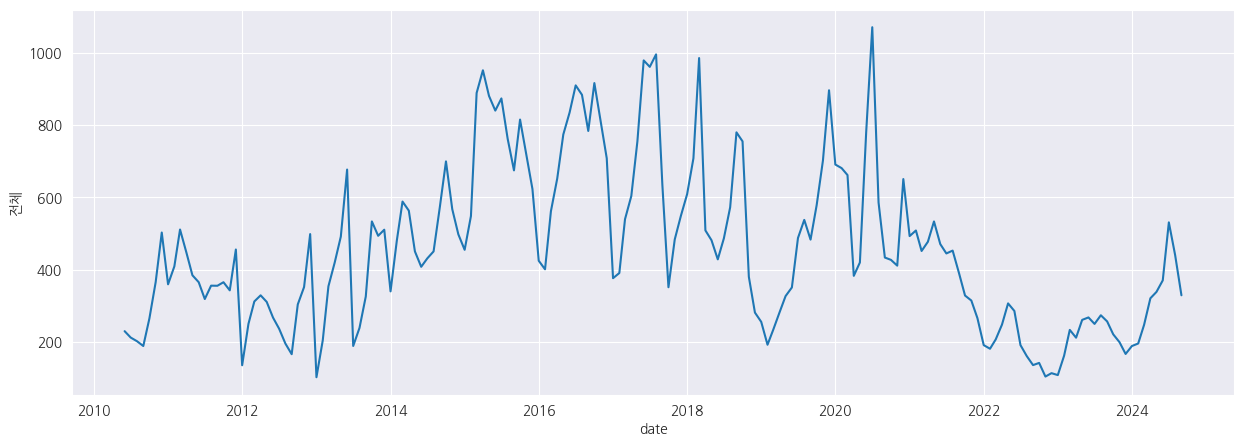

In [21]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=final_estate_volume_df, x='date', y='전체', ci=None)

plt.show()

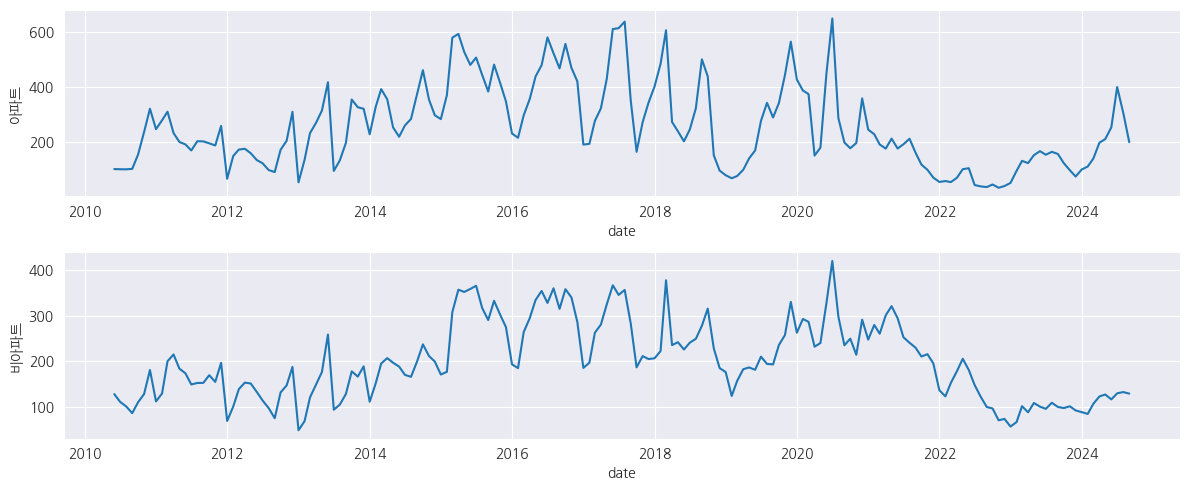

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 5))
sns.lineplot(data=final_estate_volume_df, x='date', y='아파트', ax=axes[0], ci=None)
sns.lineplot(data=final_estate_volume_df, x='date', y='비아파트', ax=axes[1], ci=None)

plt.tight_layout()
plt.show()

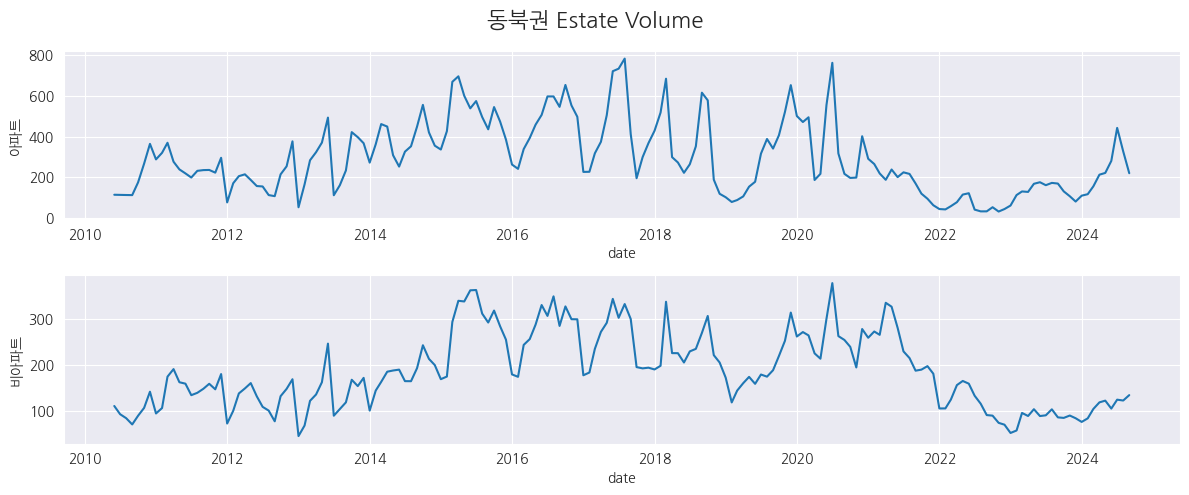

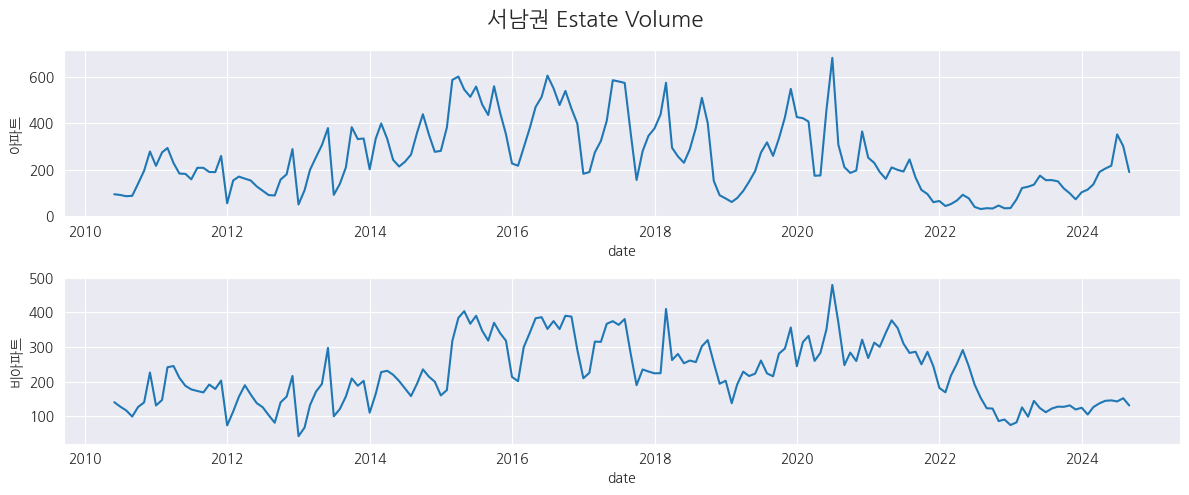

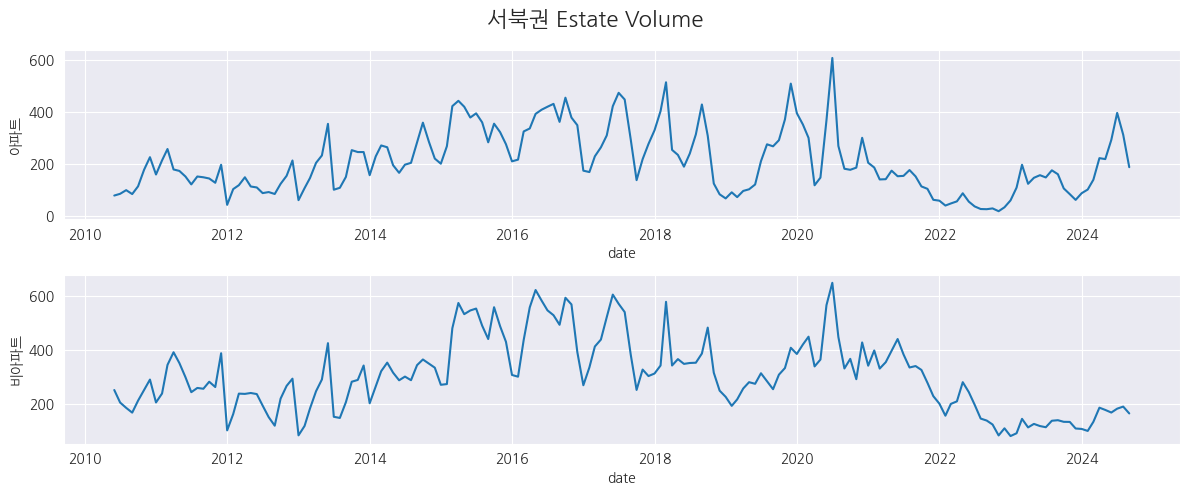

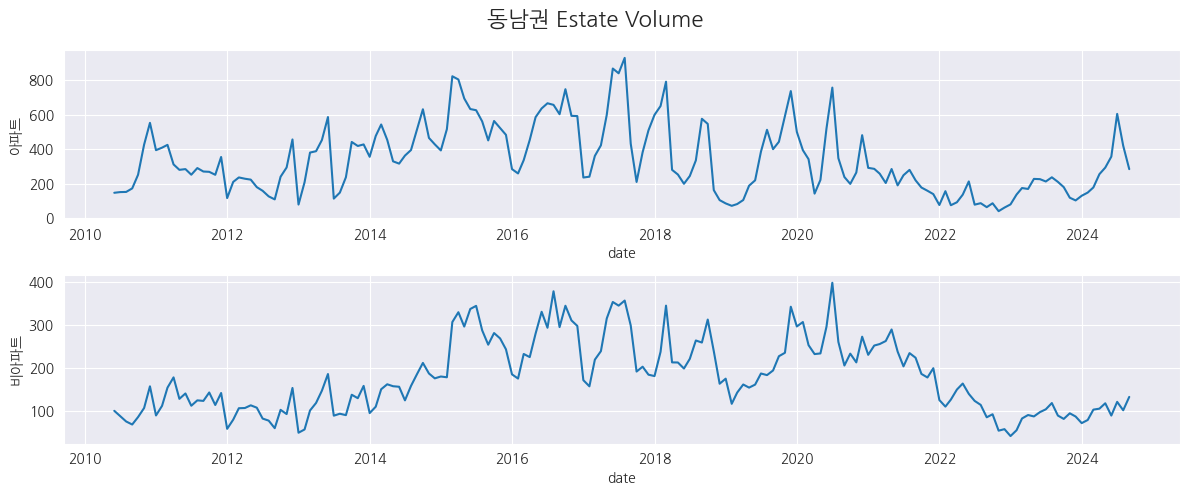

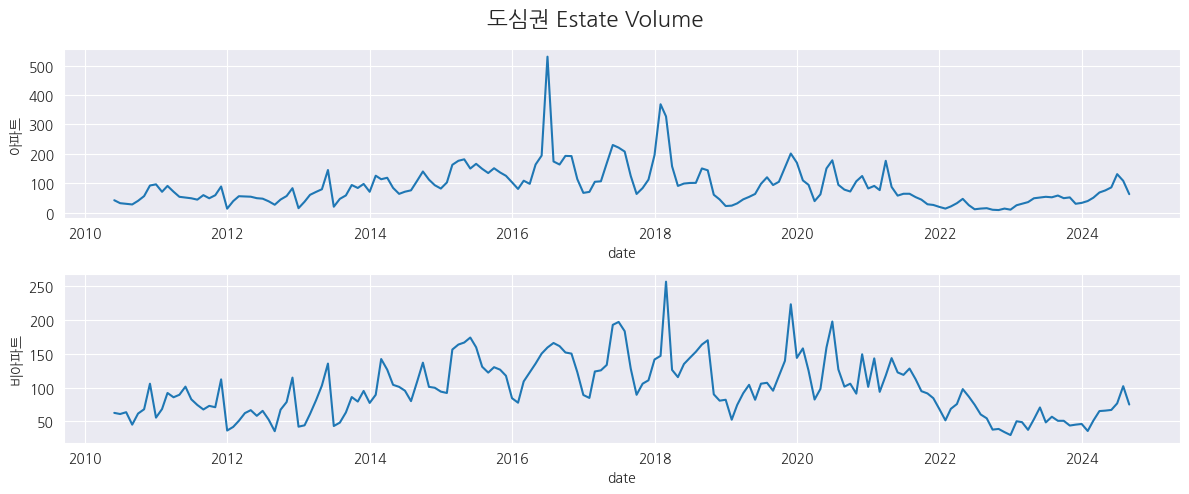

In [23]:
for district in final_estate_volume_df['생활권역'].unique():

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 5))

    fig.suptitle(f'{district} Estate Volume', fontsize=16)

    sns.lineplot(data=final_estate_volume_df.query(f"생활권역 == '{district}'"), x='date', y='아파트', ax=axes[0], ci=None)
    sns.lineplot(data=final_estate_volume_df.query(f"생활권역 == '{district}'"), x='date', y='비아파트', ax=axes[1], ci=None)

    plt.tight_layout()
    plt.show()